# INF8775 – Analyse et conception d’algorithmes
# TP1 – Automne 2024

TOURIGNY, François 2079718

CÔTÉ, Gabriel 2082508

Note finale: 

<u>**Date limite de remise :**</u>  1er Octobre 23h59 (Groupe B2), 8 Octobre 23h59 (Groupe B1)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaison). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème classique de trier une liste de nombres aléatoires.

La taille de la liste ainsi que le nombre maximal permi changeront d'un échantillon à l'autre. Vous pouvez utilisez le code fourni pour générer plus d'instances, mais on fournit aussi des instances intéressantes pour pousser votre réflexion plus loin.

## Algorithmes à implanter

On vous demande de résoudre ce problème de 5 façons différentes :

1. En utilisant un algorithme simple: `Bubble Sort` ;
2. En utilisant une amélioration de l'algorithme précédent: `Cocktail Shaker Sort` ;
3. En utilisant un algorithme diviser pour régner: `Merge Sort` ;
4. En utilisant l'algorithme précédent avec un seuil de récursivité non élémentaire ;
5. En utilisant un algorithme non comparatif: `Radix Sort`.

Pour l’algorithme 4, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est inférieure à ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 2.

Pour l'algorithme 5, on vous demande de comparer les chiffres les moins significatifs en premier (`Radix Sort LDS`).


## Jeu de données

La classe Problem existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une liste d'une taille donnée contenant des nombres entre 1 et le maximum permis. Vous pouvez utilisez des listes aléatoires pour tester votre code.

In [15]:
import random
from collections.abc import Iterable

class Problem():
    def __init__(self, size: int, max_number: int, num_samples: int = 5) -> None:
        self.size = size
        self.max_number = max_number
        self.num_samples = num_samples
    
    def generate_sample(self) -> list[int]:
        """Returns a list of the given size containing numbers between 1 and the max_number"""
        return [random.randint(1,self.max_number) for _ in range(self.size)]
    
    def generate_dataset(self) -> Iterable[list[int]]:
        """Returns an iterator over as many samples as are described """
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [16]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import log10
from scipy.stats import linregress

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, max_number: int, mean: int) -> None:
        self.size = size
        self.max_number = max_number
        self.mean = mean

def convert_list_to_dict(original: list[int]) -> dict[int:int]:
    """Converts a list into a dictionary of frequencies"""
    freq: dict[int:int] = dict()
    for iter in original:
        if iter not in freq.keys():
            freq[iter] = 0
        freq[iter] += 1
    return freq

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates both if the solution is sorted and if the list was not modified"""
    # Lists must be of equal length
    if len(solution) != len(original):
        return False
    
    # List must be in increasing order
    for i in range(1, len(solution)):
        if solution[i-1] > solution[i]:
            return False
    
    original_freq = convert_list_to_dict(original)
    solution_freq = convert_list_to_dict(solution)
    # Lists must have the same values
    for key in original_freq.keys():
        if key not in solution_freq.keys() or\
            solution_freq[key] != original_freq[key]:
            return False
    
    # Solution is valid
    return True

def make_problems(sizes: list[int], max_numbers: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    problems: list[Problem] = []
    for size in sizes:
        for max_number in max_numbers:
            problems.append(Problem(size,max_number,num_samples))
    return problems

def measure(procedure: Callable[[list[int]],list[int]], sample: list[int], time_scale: int = 1000) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return round(end - start)

def measure_mean(procedure: Callable[[list[int]],list[int]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    mean_time = sum(
        [measure(procedure,sample,time_scale) for sample in prob.generate_dataset()]
    ) / prob.num_samples
    return Measure(prob.size, prob.max_number, mean_time)

def measure_range(procedure: Callable[[list[int]],list[int]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.
    Uses a fixed max_number to measure the effect of size on its own.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    
    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def test_threshold(
    procedure: Callable[[list[int],int],list[int]],
    thresholds: list[int], problem: Problem, time_scale: int = 1000
) -> dict[int,int]:
    """Tests the different thresholds on the same problem instance."""
    threshold_measures = {t:0 for t in thresholds}
    for sample in problem.generate_dataset():
        for t in thresholds:
            start = time.time() * time_scale
            solution = procedure(sample,t)
            end = time.time() * time_scale
            if not is_valid_solution(sample,solution):
                raise InvalidSolution()
            threshold_measures[t] += (end - start) / problem.num_samples
    return threshold_measures

def estimate_threshold(
    first_data: dict[int,int],
    second_data: dict[int,int],
    first_label: str,
    second_label: str,
    y_label: str
):
    plt.plot(list(first_data.keys()),list(first_data.values()),label=first_label)
    plt.plot(list(second_data.keys()),list(second_data.values()),label=second_label)
    plt.xlabel('Taille')
    plt.ylabel(y_label)
    plt.title('Estimation du seuil')
    plt.show()

def display_threshold_measures(data: dict[int,int]):
    """Displays a graph of the time take to solve in regards to the chosen threshold"""
    x = list(data.keys())
    y = list(data.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps (ms)')
    plt.title('Selection du seuil')
    plt.show()
     
def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Nombre maximal", "Temps moyen (ms)"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.max_number, measure.mean))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())
    
    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(x, y)
    
    # Estimate the values of y based on the lin regression results
    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"
    
    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def test_de_constantes(
    data: dict[int,int],
    x_label: str,
    y_label: str = "Temps (ms)",
    title: str = "Test de constantes"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme simple (Bubble Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri bubble sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [17]:
def bubble_sort(original: list[int]) -> list[int]:
    # TODO Bubble sort
    swap = True
    while swap:
        swap = False
        for i in range(len(original)-1):
            if original[i] > original[i+1]:
                swap = True
                temp = original[i]
                original[i] = original[i+1]
                original[i+1] = temp
    return original

In [18]:
problem = Problem(10, 100)
sample = problem.generate_sample()
is_valid_solution(sample, bubble_sort(sample))

True

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

La complexité de cet algorithme est thétha de n^2 parce que pour chaque passage, on passe une fois à travers les n nombres et on va avoir à replacer les n nombres au bon endroit. Le pire cas étant quand la liste contient le nombre le plus petit à la fin alors on doit prendre chacun des nombres et aller les porter après les nombre le plus plus petit donc n fois n passages ce que nous donne une complexité de n^2.

### Mesures

Pour cet algorithme ainsi que les prochains, vous devez choisir les différentes tailles de liste que vous voulez tester. Choisissez des tailles qui ont des résultats intéressants, une taille de 5 qui se termine en une fraction de millisecondes n'est pas le meilleur résultat pour faire des comparaisons.

Pour faire des mesures, utilisez la fonction `measure_range`. Elle permet de faire des mesures sur une liste de problèmes. Vous pouvez facilement créer des problèmes en utilisant la fonction `make_problems`. Ne faites varier que la taille <u>**OU**</u> le nombre maximal pour observer le comportement d'un des deux paramètres. Le code fournit s'occupera de générer des échantillons aléatoires, de calculer le temps moyen et de vous retourner une liste de mesures. Vous pouvez utilisez la fonction `range` de python pour obtenir une grande liste et avoir plusieurs points (faites attention au temps d'exécution).

Ces données peuvent ensuite être passées aux fonctions `test_de_...` en les mettant dans un `dict` python tel que `x:y`. Les tests ont de la documentation pour expliquer leur utilisation en plus de détails.

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [19]:
# TODO take measurements
results_size_change = measure_range(bubble_sort, make_problems([10*x for x in range(1, 101)], [10000 for _ in range(10)]))

In [20]:
results_max_number = measure_range(bubble_sort, make_problems([500 for _ in range(10)], [100*x for x in range(1, 101)]))

In [21]:
def dict_size_from_measures(measures: list[Measure]) -> dict:
    dict = {}
    for measure in measures:
        dict[measure.size] = measure.mean
    return dict

In [22]:
def dict_max_number_from_measures(measures: list[Measure]) -> dict:
    dict = {}
    for measure in measures:
        dict[measure.max_number] = measure.mean
    return dict

In [23]:
dict_results_size = dict_size_from_measures(results_size_change)
dict_results_max_number = dict_max_number_from_measures(results_max_number)

In [24]:
# TODO Display data as tables
display_data_as_table(results_size_change)
print(dict_results_size)
display_data_as_table(results_max_number)
print(dict_results_max_number)

Taille       Nombre maximal Temps moyen (ms)
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

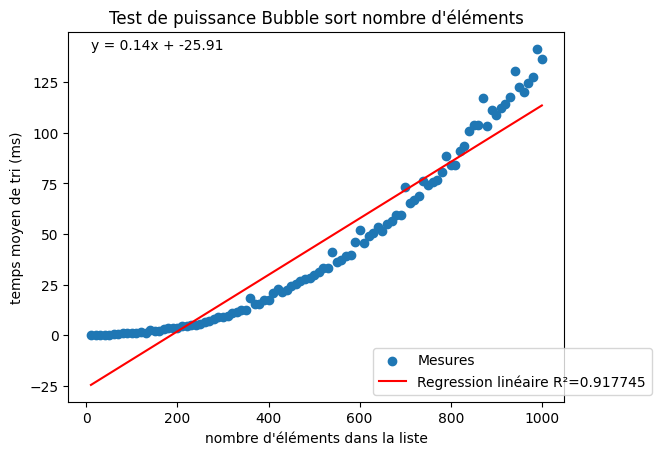

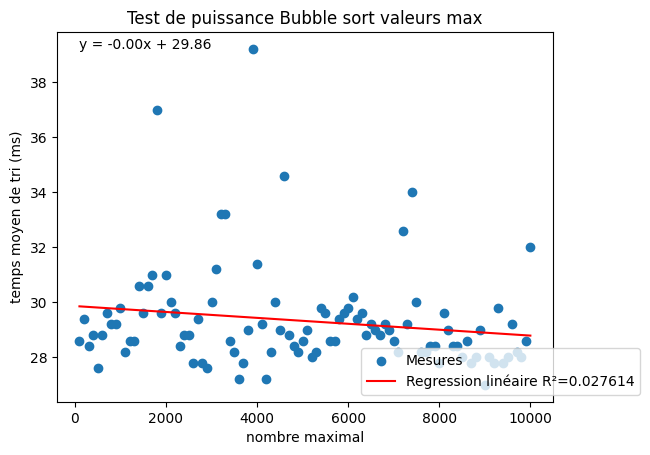

In [25]:
# TODO Test de puissance
test_de_puissance(dict_results_size, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Bubble sort nombre d'éléments")
test_de_puissance(dict_results_max_number, "nombre maximal", 'temps moyen de tri (ms)', 'Test de puissance Bubble sort valeurs max')

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Avec les graphiques obtenus nous voyons que la puissance semble être définie par une relation exponentielle. En effet, l'augmentation du nombre d'éléments croit plus rapidement qu'une relation polynomiale. Au niveau du changement de la grosseur des nombres utilisés, on ne voit aucune augmentation du temps de tri par rapport aux valeurs. Le rapport entre le temps de tri et la grosseur des chiffres serait linéaire comme il n'y a aucune incidence entre la valeur maximale et le temps de tri.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

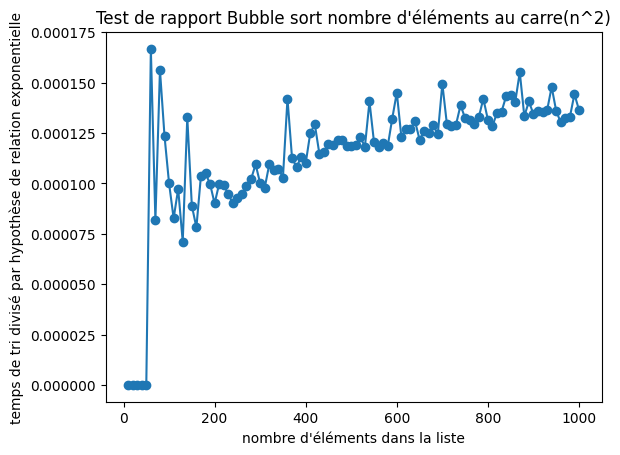

In [26]:
# TODO Test de rapport
def change_to_predict(init_dict: dict, hypothesis = lambda x: x) -> dict:
    new_dict = {}
    for key in init_dict:
        new_dict[key] = init_dict[key]/hypothesis(key)
    return new_dict

test_de_rapport(change_to_predict(dict_results_size, lambda x: x**2), "nombre d'éléments dans la liste", 'temps de tri divisé par hypothèse de relation exponentielle', "Test de rapport Bubble sort nombre d'éléments au carre(n^2)")

# le test de rapport pour la valeur maximale n<est pas pertinent comme nous avons une relation qui ne dépend pas de x. Il est donc impossible de faire un graphe
#test_de_rapport(change_to_predict(dict_results_max_number, lambda x: 1), "nombre maximal", 'temps de tri divisé par hypothèse de relation constante', 'Test de rapport Bubble sort valeurs max correlation de O(1)')

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

On voit que les valeurs semblent se rendre vers une valeur et converger. On voit donc que notre hypothèse de relation exponentielle semble bonne comme il existe une constante vers lequel on converge.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

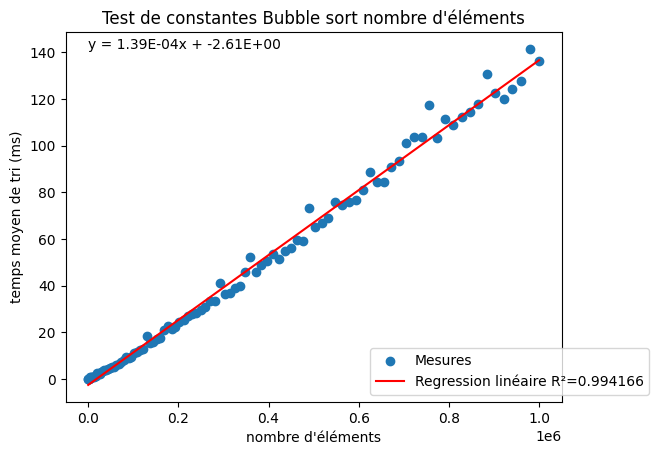

In [27]:
# TODO Test des constantes

def change_x_to_predict(init_dict: dict, hypothesis = lambda x: x) -> dict:
    new_dict = {}
    for key in init_dict:
        new_dict[hypothesis(key)] = init_dict[key]
    return new_dict

test_de_constantes(change_x_to_predict(dict_results_size, lambda x: x**2), "nombre d'éléments", 'temps moyen de tri (ms)', "Test de constantes Bubble sort nombre d'éléments")
#
# le test de constante n<est pas pertinent pour une relation lineaire et donc deja constante
# test_de_constantes(change_x_to_predict(dict_results_max_number, lambda x: 1), "grosseur maximale des nombres", 'temps moyen de tri (ms)', 'Test de constantes Bubble sort valeurs max')

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Selon le test de constante que nous avons, la relation de puissance serait bel et bien exponentielle. Le facteur de correlation de la droite est de plus de 99 pourcent.

## Partie 2 : Algorithme amélioré (Cocktail Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri cocktail sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [28]:
def cocktail_sort(original: list[int]) -> list[int]:
    # TODO
    swap = True
    while swap:
        swap = False
        for i in range(len(original)-1):
            if original[i] > original[i+1]:
                swap = True
                temp = original[i]
                original[i] = original[i+1]
                original[i+1] = temp
        if not swap:
            break
        for i in range(len(original)-1, 1, -1):
            if original[i] < original[i-1]:
                swap = True
                temp = original[i]
                original[i] = original[i-1]
                original[i-1] = temp
    return original

In [29]:
problem = Problem(10, 100)
sample = problem.generate_sample()
is_valid_solution(sample, cocktail_sort(sample))

True

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

Ici, nous avons une complexité asymptotique de theta(n^2), parce que chaque fois qu'on rentre dans le loop on fait n + n. On rentre dans la boucle while en moyenne n fois, alors on a T(n) = n*(n+n) = n^2

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [30]:
# TODO take measurements
results_size_change_cocktail = measure_range(cocktail_sort, make_problems([10*x for x in range(1, 101)], [10000 for _ in range(10)]))

In [31]:
results_max_number_cocktail = measure_range(cocktail_sort, make_problems([500 for _ in range(10)], [100*x for x in range(1, 101)]))

In [32]:
dict_results_size_cocktail = dict_size_from_measures(results_size_change_cocktail)
dict_results_max_number_cocktail = dict_max_number_from_measures(results_max_number_cocktail)

In [33]:
# TODO Display data as tables
display_data_as_table(results_size_change_cocktail)
print(dict_results_size_cocktail)
display_data_as_table(results_max_number_cocktail)
print(dict_results_max_number_cocktail)

Taille       Nombre maximal Temps moyen (ms)
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
10           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
20           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000        0.0         
30           10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

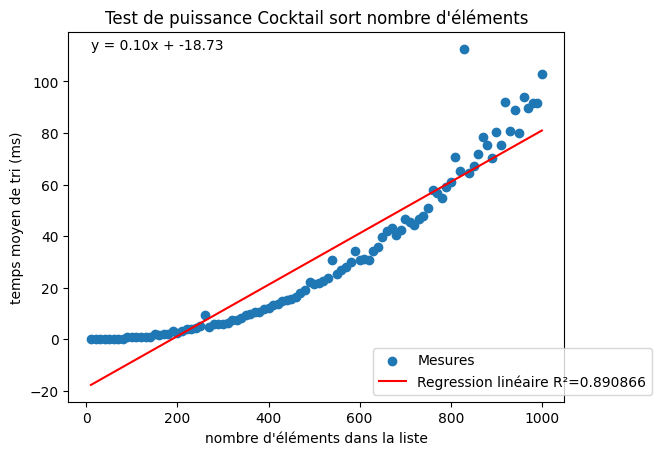

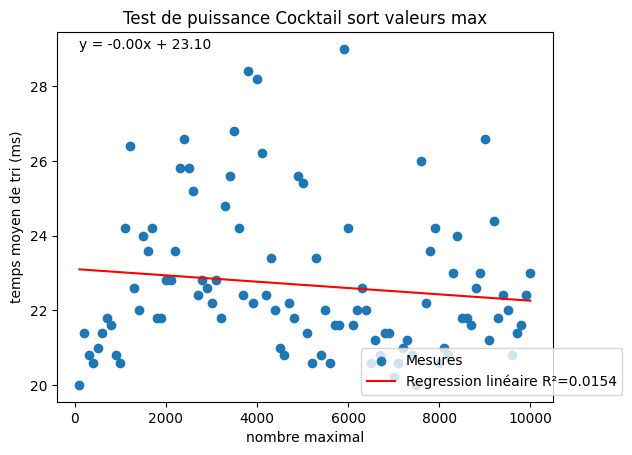

In [34]:
# TODO Test de puissance
test_de_puissance(dict_results_size_cocktail, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Cocktail sort nombre d'éléments")
test_de_puissance(dict_results_max_number_cocktail, "nombre maximal", 'temps moyen de tri (ms)', 'Test de puissance Cocktail sort valeurs max')

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Comme pour le tri par bulle, nous voyons que la relation linéaire n'est pas la bonne. On remarque que le temps de tri augmente beaucoup plus rapidement que le nombre d'exemplaire à trier. Le tri cocktail serait donc aussi une relation exponentielle entre le nombre d'éléments et le temps de tri. Au niveau du nombre de valeurs ça ne semble pas influencer du tout le temps de tri. Bref, le temps de tri serait constant par rapport à la grosseur des nombres.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

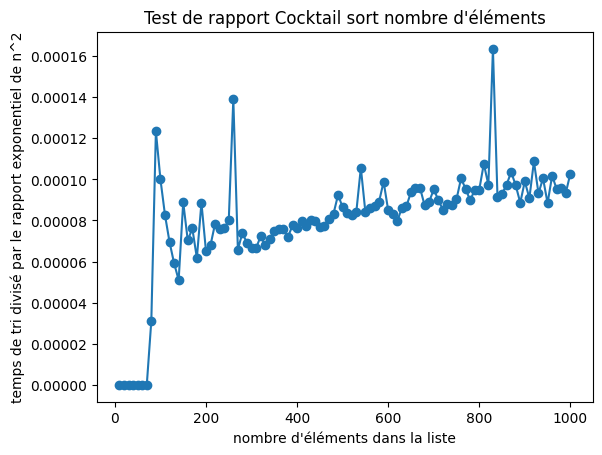

In [35]:
# TODO Test de rapport
test_de_rapport(change_to_predict(dict_results_size_cocktail, lambda x: x**2), "nombre d'éléments dans la liste", 'temps de tri divisé par le rapport exponentiel de n^2', "Test de rapport Cocktail sort nombre d'éléments")
#test_de_rapport(dict_results_max_number_cocktail, "nombre maximal", 'temps moyen de tri (ms)', 'Test de rapport Cocktail sort valeurs max')

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

On voit comme notre intuition le prédisait que le rapport semble être exponentiel. En effet, il semble y avoir une convergence vers une valeur constante.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

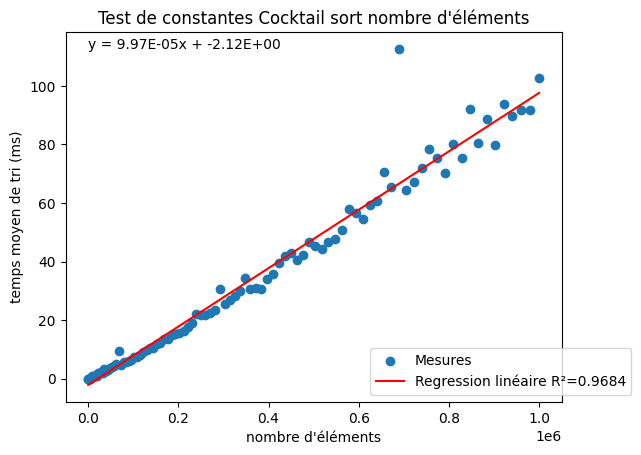

In [36]:
# TODO Test des constantes
test_de_constantes(change_x_to_predict(dict_results_size_cocktail, lambda x: x**2), "nombre d'éléments", 'temps moyen de tri (ms)', "Test de constantes Cocktail sort nombre d'éléments")
#test_de_constantes(dict_results_max_number_cocktail, "grosseur maximale des nombres", 'temps moyen de tri (ms)', 'Test de constantes Cocktail sort valeurs max')

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Tout comme pour le tri par bulle, une valeur de convergence semble être atteinte. Par contre, cette fois-ci la valeur est significativement plus petite que 1. Le tri cocktail est donc de relation de complexité n^2 tout comme le tri par bulle, mais malgré tout beaucoup plus efficace.

## Partie 3 : Algorithme diviser pour régner (Merge Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri merge sort. Cette algorithme utilise le patron de conception "Diviser pour régner".

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [37]:
def merge_sort(original: list[int]) -> list[int]:
    # TODO
    if len(original) <= 1:
        return original
    #split
    left = merge_sort(original[:int(len(original)/2)])
    right = merge_sort(original[int(len(original)/2):])
    #merge
    merge_result = []
    i = 0
    j = 0
    while i < len(left) or j < len(right):
        if i < len(left) and (not j < len(right) or left[i] < right[j]):
            merge_result.append(left[i])
            i += 1
        else:
            merge_result.append(right[j])
            j += 1
    return merge_result

In [38]:
problem = Problem(10, 100)
sample = problem.generate_sample()
is_valid_solution(sample, merge_sort(sample))

True

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

La complexité asymptotique de l'algorithme de tri par fusion est de n log(n). En effet, pour completement diviser le tableau nous avons une complexité de log(n) éléments, car nous avons toujours une division par 2. Au niveau de reconstruire le tableau en triant, nous avons une complexité de n. Lorsque nous avons l'algorithme complet avec toutes les étapes ensembles, la complexité de la division et de la reconstruction nous donne n log(n)

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [39]:
# TODO take measurements
results_size_change_merge = measure_range(merge_sort, make_problems([100*x for x in range(1, 101)], [10000 for _ in range(10)]))

In [40]:
results_max_number_merge = measure_range(merge_sort, make_problems([500 for _ in range(10)], [100*x for x in range(1, 101)]))

In [41]:
dict_results_size_merge = dict_size_from_measures(results_size_change_merge)
dict_results_max_number_merge = dict_max_number_from_measures(results_max_number_merge)

In [42]:
# TODO Display data as tables
display_data_as_table(results_size_change_merge)
print(dict_results_size_merge)
display_data_as_table(results_max_number_merge)
print(dict_results_max_number_merge)

Taille       Nombre maximal Temps moyen (ms)
100          10000        1.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.4         
100          10000        0.8         
100          10000        0.6         
100          10000        0.2         
100          10000        1.0         
100          10000        0.8         
100          10000        0.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
300          10000        1.0         
300          10000        1.4         
300          10000        1.8         
300          10000        1.2         
300          10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

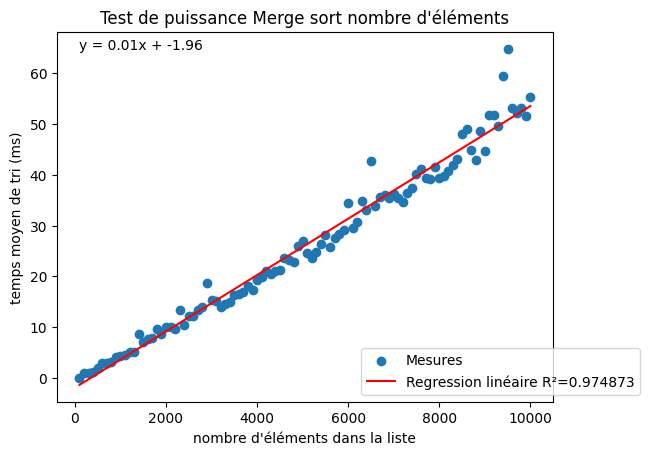

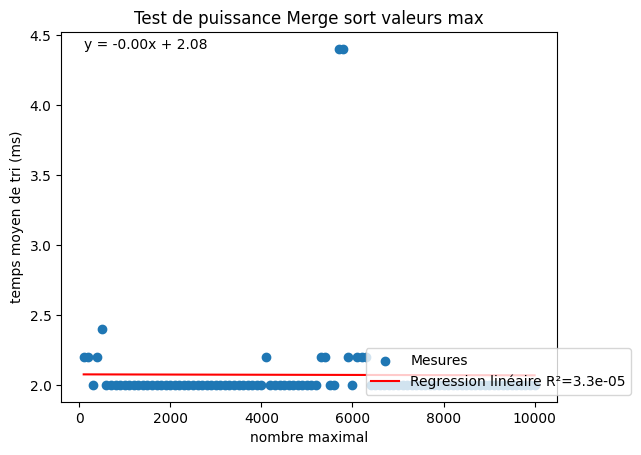

In [43]:
# TODO Test de puissance
import math
test_de_puissance(dict_results_size_merge, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort nombre d'éléments")
test_de_puissance(dict_results_max_number_merge, "nombre maximal", 'temps moyen de tri (ms)', 'Test de puissance Merge sort valeurs max')

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Nous voyons que la relation n'est pas vraiment linéaire entre le nombre d'éléments à classer et le temps pour les trier. En effet, nous supposons que la relation serait plutôt d'ordre n log(n). Pour ce qui est de la relation entre le nombre de valeurs et la grosseur des nombres, il ne semble y avoir aucune relation. Bref, la relation entr ele temps de tri et la grosseur des nombres serait linéaire.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

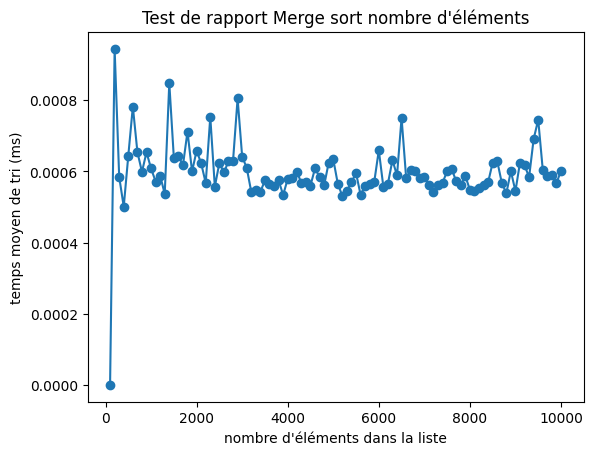

In [44]:
# TODO Test de rapport
test_de_rapport(change_to_predict(dict_results_size_merge, lambda x: x * math.log(x)), "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de rapport Merge sort nombre d'éléments")
#test_de_rapport(dict_results_max_number_merge, "nombre maximal", 'temps moyen de tri (ms)', 'Test de rapport Merge sort valeurs max')

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

On voit que malgré les sauts de valeurs, sur une plus grande tendance, nous aurions une convergence vers une valeur. En effet, le ratio augmente, mais toujours de plus en plus lentement, ce qui indique que n log(n) est le bon ordre de croissance du temps de tri selon le nombre d'éléments.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

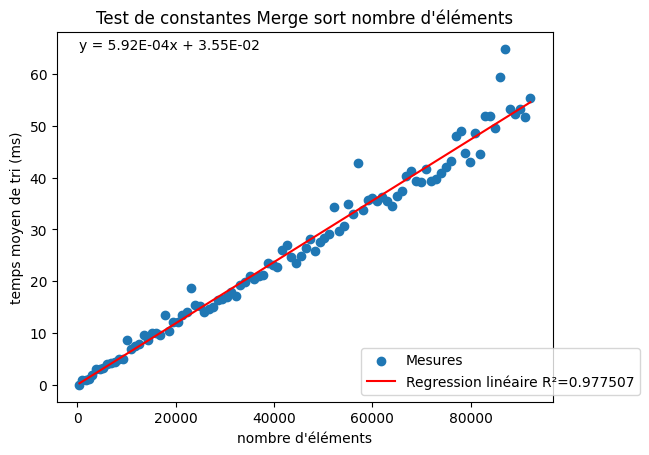

In [45]:
# TODO Test des constantes
test_de_constantes(change_x_to_predict(dict_results_size_merge, lambda x: x * math.log(x)), "nombre d'éléments", 'temps moyen de tri (ms)', "Test de constantes Merge sort nombre d'éléments")
#test_de_constantes(dict_results_max_number_merge, "grosseur maximale des nombres", 'temps moyen de tri (ms)', 'Test de constantes Merge sort valeurs max')

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

On voit que la relation semble être respectée et nous donner une valeur petite de 0,000516 comme constante multiplicative. Par contre, pour de petites valeurs on voit des plateaux donc le résultat prévu peut être un peu loin de la réalité. Par contre, plus les valeurs grossissent, plus l'estimation semble précise.

<u>**Question 4.c):**</u> Quel serait un meilleur choix de seuil? Utilisez la fonction `estimate_threshold` pour avoir une idée où commencer. Analysez le graph résultant et choisissez un seuil de départ.

On recommande de compiler des nouvelles données sur des tailles plus petites. Utilisez un `time_scale` plus grand pour avoir plus de détails (indiquez les unités dans le `y_label`). Une fois que vous avez une idée d'où se situe le point de croisement, vous pouvez refaire le test sur une sélection plus restreinte de tailles en augmentant `num_samples` pour avoir des résultats plus constants.

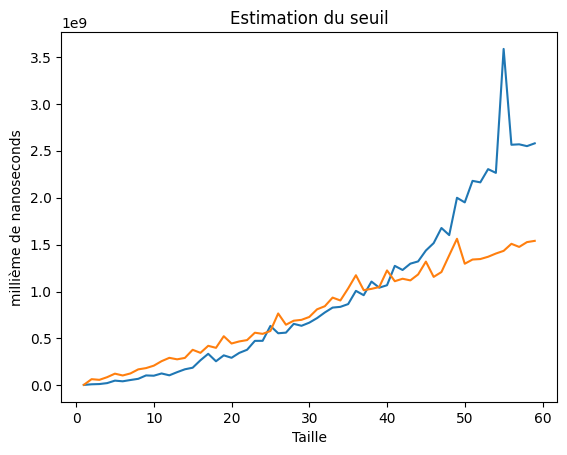

In [46]:
# TODO Find a better starting point for the threshold
small_merge = measure_range(merge_sort, make_problems([x for x in range(1, 60)], [10000 for _ in range(10)]), 10000000000000)
small_cocktail = measure_range(cocktail_sort, make_problems([x for x in range(1, 60)], [10000 for _ in range(10)]), 10000000000000)
dict_results_size_merge_small = dict_size_from_measures(small_merge)
dict_results_size_cocktail_small = dict_size_from_measures(small_cocktail)
# merge sort in orange, cocktail in blue
estimate_threshold(dict_results_size_cocktail_small, dict_results_size_merge_small, "cocktail", "merge sort", "millième de nanoseconds")

On voit dans ce graphe que la valeur de 32 semble être le point de transition entre avoir un algorithme n**2 et n log(n). Bref, on aurait avantage à utiliser le cocktail sort pour els échantillons de moins de 32 éléments.

## Partie 4 : Algorithme diviser pour régner avec seuil arbitraire (Merge Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Reprenez l'algorithme précédent et modifiez-le pour y ajouter un seuil de récursivité. En dessous de ce seuil, vous utiliserez l'algorithme `cocktail_sort` écrit précédemment.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [47]:
def merge_sort_threshold(original: list[int], threshold: int = 32) -> list[int]:
    # TODO
    if len(original) <= threshold:
        return cocktail_sort(original)
    #split
    left = merge_sort_threshold(original[:int(len(original)/2)])
    right = merge_sort_threshold(original[int(len(original)/2):])
    #merge
    merge_result = []
    i = 0
    j = 0
    while i < len(left) or j < len(right):
        if i < len(left) and (not j < len(right) or left[i] < right[j]):
            merge_result.append(left[i])
            i += 1
        else:
            merge_result.append(right[j])
            j += 1
    return merge_result

<u>**Question 1.b):**</u> À l'aide de ce que vous avez vu dans la section précédente, effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux. Affichez les dans un graphique une fois que les mesures sont compilées. La fonction `test_threshold` vous sera utile pour faire ces tests. Choisissez bien vos seuils ainsi qu'une taille de liste permettant de bien observer la différence de performance.

In [48]:
# TODO Test different threshold values premiere exploration
problem = Problem(100000, 100000, 10)
threshold_results = test_threshold(merge_sort_threshold, [x for x in range(5, 40)], problem, 1000)

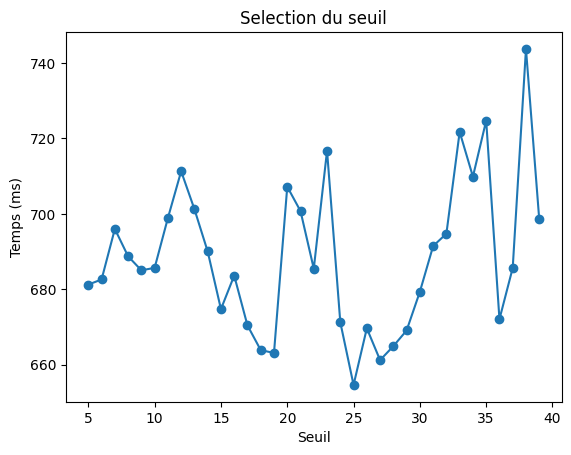

In [49]:
# TODO Display a graph with the measurements
display_threshold_measures(threshold_results)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité le plus judicieux? Sur quel critère l'avez vous sélectionné? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances?

Changez le seuil par défaut de votre fonction au meilleur choix. Ceci vous permettra d'utiliser les fonctions utilitaires sans passer le seuil comme argument.

Le meilleur seuil est de 32 éléments parce que nous pouvons voir que les valeurs plus grandes ou plus faibles donnent de moins bonnes performances. En effet, lorsque les valeurs sont faibles, subdiviser en plus de groupes avec un algorithme diviser pour régner est plus lent que de traiter ce petit groupe de données. Avec aussi peu d'éléments, la grande complexité assymptotique du cocktail sort ne se fait pas ressentir et est donc plus efficace que de continuer d'appliquer du diviser pour régner.

<u>**Question 1.d):**</u> La complexité asymptotique théorique de cet algorithme a-t-elle changée? Veuillez justifier.

Non, la complexité asymptotique de l'algorithme ne change pas selon le seuil choisi. En effet, la complexité asymptotique dépend du comportement lorsque n tend vers l'infini et un seuil statique n'est pas à considérer lorsqu'on regarde les tendances lors de l'augmentation de n. Par contre, un seuil a des impacts concrets sur le temps réel de tri.

### Mesures

<u>**Question 1.e):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [50]:
# TODO take measurements
results_size_change_merge_threshold = measure_range(merge_sort_threshold, make_problems([100*x for x in range(1, 101)], [10000 for _ in range(10)]))
results_max_number_merge_threshold = measure_range(merge_sort_threshold, make_problems([1000 for _ in range(10)], [100*x for x in range(1, 101)]))
dict_results_size_merge_threshold = dict_size_from_measures(results_size_change_merge_threshold)
dict_results_max_number_merge_threshold = dict_max_number_from_measures(results_max_number_merge_threshold)
display_data_as_table(results_size_change_merge_threshold)
print(dict_results_size_merge_threshold)
display_data_as_table(results_max_number_merge_threshold)
print(dict_results_max_number_merge_threshold)

Taille       Nombre maximal Temps moyen (ms)
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.2         
100          10000        0.0         
100          10000        0.0         
100          10000        0.2         
100          10000        0.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
200          10000        1.0         
300          10000        2.0         
300          10000        1.6         
300          10000        1.0         
300          10000        1.0         
300          10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

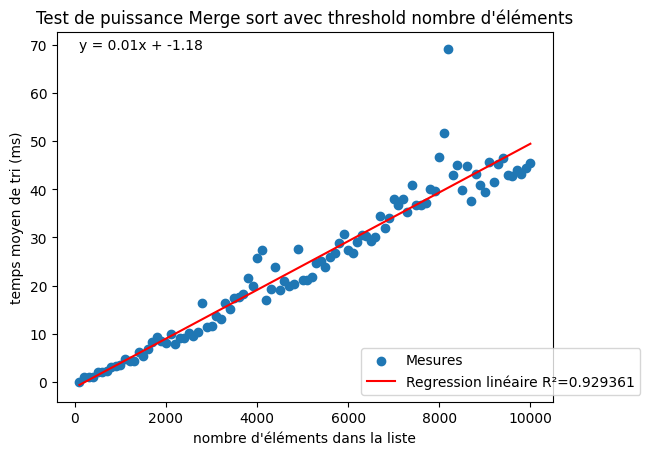

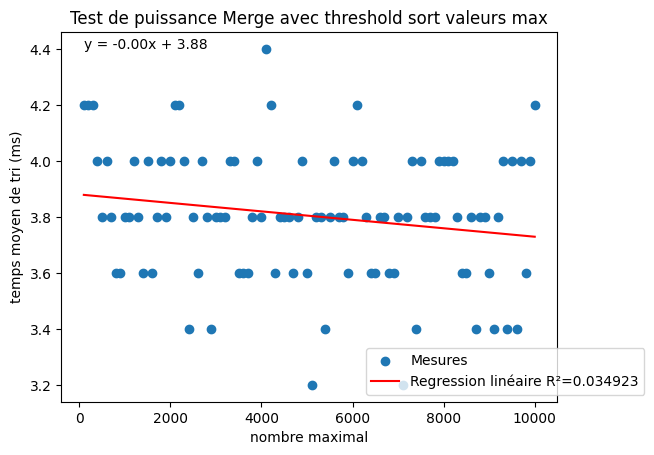

In [51]:
# TODO Test de puissance
test_de_puissance(dict_results_size_merge_threshold, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance Merge sort avec threshold nombre d'éléments")
test_de_puissance(dict_results_max_number_merge_threshold, "nombre maximal", 'temps moyen de tri (ms)', 'Test de puissance Merge avec threshold sort valeurs max')

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

On peut voir dans le premier graphique que le temps de tri semble avoir une augmentation légèrement plus grande que polynomiale. On peut donc supposer que la relation est n log(n). Au niveau du plus grand nombre comparé au temps de tri, la relation semble constante.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

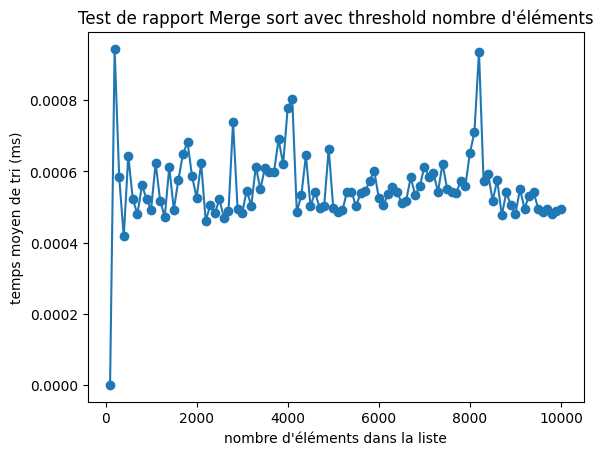

In [52]:
# TODO Test de rapport
test_de_rapport(change_to_predict(dict_results_size_merge_threshold, lambda x: x * math.log(x)), "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de rapport Merge sort avec threshold nombre d'éléments")
# 
# relation initéressante parce que la relation semble constante et non en fonction du plus gros nombre à trier
# test_de_rapport(dict_results_max_number_merge_threshold, "nombre maximal", 'temps moyen de tri (ms)', 'Test de rapport Merge sort avec threshold valeurs max')

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Le graphe semble montrer une convergence vers une valeur. Ainsi, nous savons que nous sommes dans le bon ordre de complexité de relation entre le nombre d'éléments à trier et le temps de tri qui suivent une relation n log(n).

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

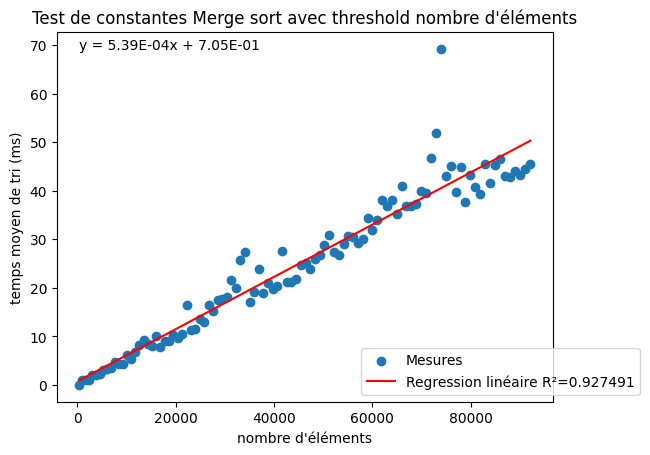

In [53]:
# TODO Test des constantes
test_de_constantes(change_x_to_predict(dict_results_size_merge_threshold, lambda x: x * math.log(x)), "nombre d'éléments", 'temps moyen de tri (ms)', "Test de constantes Merge sort avec threshold nombre d'éléments")
#test_de_constantes(dict_results_max_number_merge_threshold, "grosseur maximale des nombres", 'temps moyen de tri (ms)', 'Test de constantes Merge sort avec threshold valeurs max')

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

On voit que le temps de traitement lorsqu'on utilise des algorithmes différents pour un petit nombre d'éléments permet de sauver du temps de calcul. En effet, la différence de la constante par rapport au tri par fusion sans seuil et avec seuil indique que cet algorithme est un peu plus rapide. Par contre, on peut voir une valeur abérante tirer l'estimé moyen de temps vers le haut.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Le seuil de récursivité réduit le temps de calcul, car le nombre de division dans diviser pour règner est inefficace en dessous d'un certain seuil. Par contre, il est important de mentionner que bien que dans les faits un seuil améliore la rapidité de tri, le temps asymptotique de l'algorithme de tri par fusion ne prend pas en compte l'utilisation ou non d'un seuil. Bref, le tri par fusion est toujours de complexité n log(n)

## Partie 5 : Algorithme non comparatif (Radix Sort LSD) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri radix sort. Cette algorithme ne fait pas de comparaison entre les différents éléments de la liste.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [54]:
def radix_sort(original: list[int]) -> list[int]:
    max_num = max(original)
    exp = 1
    while max_num // exp > 0:
        count = [0] * 10
        output = [0] * len(original)

        for num in original:
            index = (num // exp) % 10
            count[index] += 1

        for i in range(1, 10):
            count[i] += count[i - 1]

        for i in range(len(original) - 1, -1, -1):
            index = (original[i] // exp) % 10
            output[count[index] - 1] = original[i]
            count[index] -= 1

        original = output
        exp *= 10

    return original

In [55]:
problem = Problem(10, 100)
sample = problem.generate_sample()
is_valid_solution(sample, radix_sort(sample))

True

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Veuillez justifier.

La complexité asymptotique est Theta de (nd), où n est la taille de l'exemplaire et d est le nombre de chiffres dans le plus gros nombre de l'exemplaire. Par exemple, si le plus gros nombre est 57, alors d = 2. On passe d fois dans le premier loop et (n + 10 + n) fois dans les 2e loop. 

<u>**Question 1.c):**</u> Comment cet algorithme ce distingue-t-il des algorithmes précédents? Est-ce toujours un avantage? Expliquez.

Cet algorithme se distingue des autres, car il n'est qu'en relation linéaire avec le nombre d'élément. Les autres algorithmes présentés ont au moins une complexité asymptotique de n log(n). Pour de grandes valeurs de n, utiliser le radix sort peut être plus avantageux. Par contre, le radix trie en temps également proportionnel au nombre de digits dans le plus grand des nombres à trier. Il n'est donc pas plus rapide d'utiliser le radix sort que les autres méthodes lorsque le nombre de digits est plus grands que le log de n (ou seulement n en comparaison avec le cocktail sort et bubble sort). Bref, il faut que le nombre de digits d soit plus petit que le log du nombre d'éléments pour être plus intéressant asymptotiquement que le tri par fusion.

### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [56]:
results_size_change_radix = measure_range(radix_sort, make_problems([100*x for x in range(1, 101)], [10000 for _ in range(10)]))
results_max_number_radix = measure_range(radix_sort, make_problems([1000 for _ in range(10)], [10**x for x in range(1, 51)]))

dict_results_size_radix = dict_size_from_measures(results_size_change_radix)
dict_results_max_number_radix = dict_max_number_from_measures(results_max_number_radix)

display_data_as_table(results_size_change_radix)
print(dict_results_size_radix)
display_data_as_table(results_max_number_radix)
print(dict_results_max_number_radix)

Taille       Nombre maximal Temps moyen (ms)
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
100          10000        0.0         
200          10000        0.0         
200          10000        0.0         
200          10000        0.0         
200          10000        0.4         
200          10000        0.2         
200          10000        0.2         
200          10000        0.0         
200          10000        0.0         
200          10000        0.0         
200          10000        0.0         
300          10000        0.2         
300          10000        0.6         
300          10000        1.0         
300          10000        1.0         
300          10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

{2: 1.0, 3: 1.0, 4: 1.0, 5: 1.8, 6: 2.0, 7: 2.6, 8: 5.2, 9: 4.4, 10: 4.2, 11: 6.2, 12: 6.0, 13: 6.2, 14: 7.0, 15: 7.2, 16: 7.2, 17: 8.0, 18: 8.2, 19: 9.2, 20: 10.2, 21: 11.0, 22: 11.2, 23: 12.4, 24: 14.4, 25: 13.2, 26: 14.0, 27: 15.8, 28: 17.2, 29: 16.6, 30: 18.6, 31: 18.6, 32: 18.2, 33: 19.0, 34: 18.8, 35: 21.4, 36: 20.2, 37: 20.6, 38: 21.6, 39: 22.6, 40: 23.6, 41: 24.6, 42: 24.4, 43: 29.8, 44: 35.6, 45: 28.4, 46: 29.4, 47: 33.2, 48: 31.2, 49: 31.2, 50: 33.2, 51: 32.0}


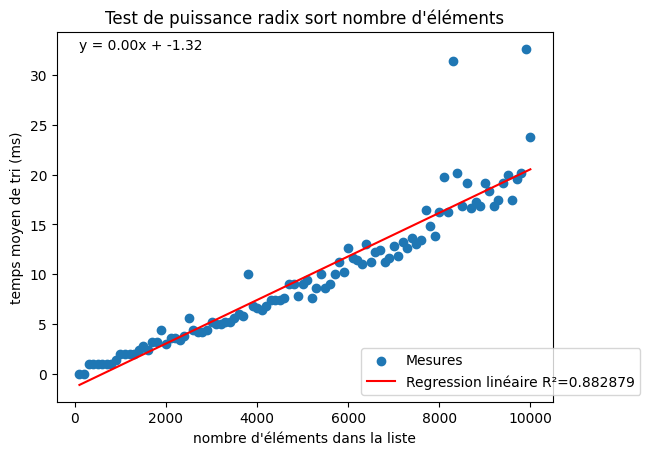

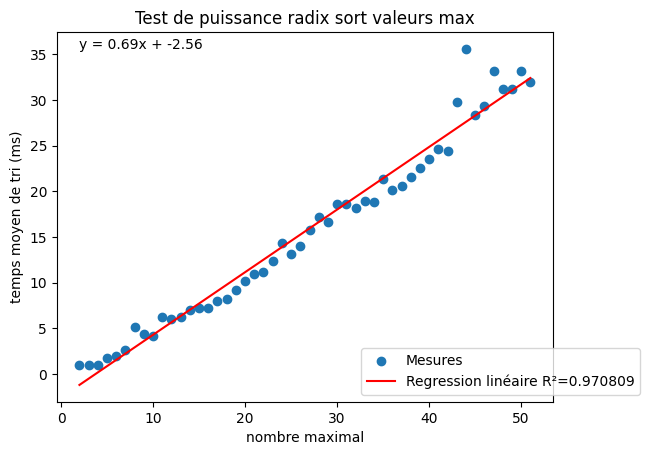

In [57]:
def dict_max_number_to_linear_dict(dict_max_number):
    new_dict = {}
    for key in dict_max_number.keys():
        # print(str(key))
        # print(len(str(key)))
        new_dict[len(str(key))] = dict_max_number[key]
    return new_dict

dict_number_of_digits = dict_max_number_to_linear_dict(dict_results_max_number_radix)
print(dict_number_of_digits)

test_de_puissance(dict_results_size_radix, "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de puissance radix sort nombre d'éléments")
test_de_puissance(dict_number_of_digits, "nombre maximal", 'temps moyen de tri (ms)', 'Test de puissance radix sort valeurs max')

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

On voit que pour les deux facteurs, le nombre d'éléments ainsi que le nombre de digits du plus gros élément, nous avons une relation linéaire. En effet, lorsqu'on varie un des deux, le temps de tri change de manière linéaire. Nous estimons donc que les deux facteurs affectent le temps de tri de manière polynomiale.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

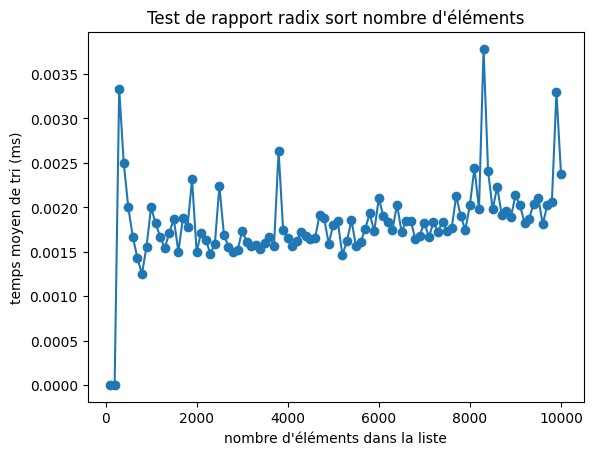

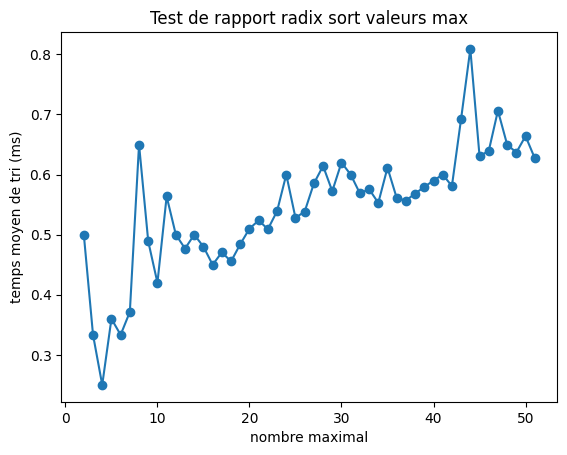

In [58]:
# TODO Test de rapport
test_de_rapport(change_to_predict(dict_results_size_radix, lambda x: x), "nombre d'éléments dans la liste", 'temps moyen de tri (ms)', "Test de rapport radix sort nombre d'éléments")
test_de_rapport(change_to_predict(dict_number_of_digits, lambda x: x), "nombre maximal", 'temps moyen de tri (ms)', 'Test de rapport radix sort valeurs max')

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Pour le graphe du temps de tri en fonction du nombre d'élément, nous voyons que les valeurs convergent donc nous savons que la relation polynomiale est le bon ordre de grandeur. Au niveau de la relation entre le temps de tri et le plus grand digit, on voit aussi une convergence asymptotiquement ce qui veut dire que la relation polynomiale est le bon ordre de grandeur.

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

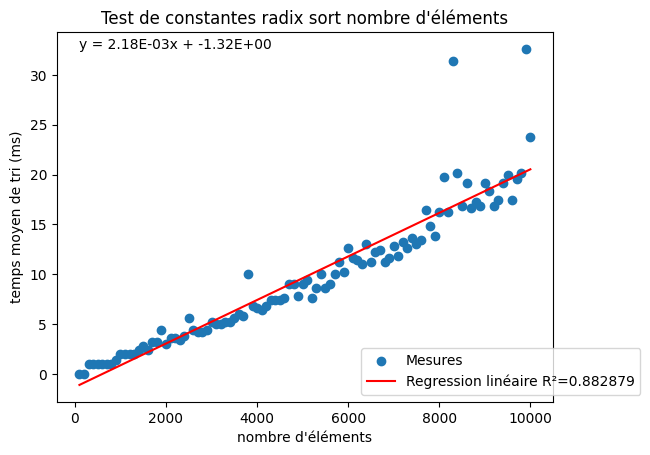

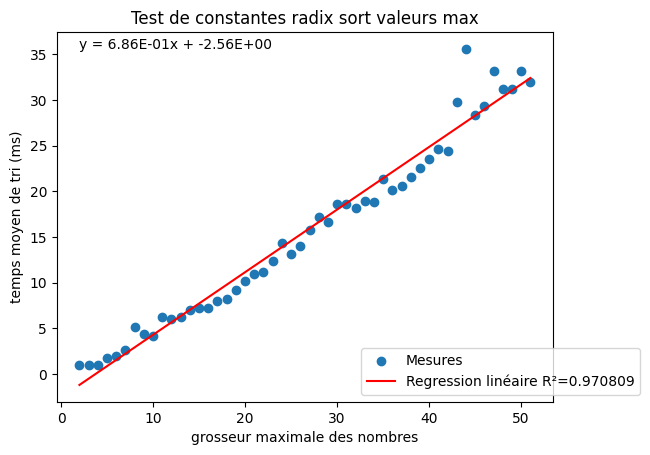

In [59]:
# TODO Test des constantes
test_de_constantes(change_x_to_predict(dict_results_size_radix, lambda x: x), "nombre d'éléments", 'temps moyen de tri (ms)', "Test de constantes radix sort nombre d'éléments")
test_de_constantes(change_x_to_predict(dict_number_of_digits, lambda x: x), "grosseur maximale des nombres", 'temps moyen de tri (ms)', 'Test de constantes radix sort valeurs max')

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Pour la relation entre le temps de tri et le nombre d'éléments nous avons une valeur de 0,00189 éléments par milliseconde. Pour le nombre de digit dans le plus gros nombre, nous avons une relation polynomiale avec un facteur de 0,673 qui est significativement plus grand que le facteur pour le nombre d'élément même si les deux sont du même ordre de complexité.

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces algorithmes.

Nous avons découvert que différents algorithmes de tri on des intérêt différent. Les algorithmes comme le cocktail sort dont le temps de tri croit exponentiellement sont mauvais pour de grandes quantités de nombres, mais peuvent être intéressants en bas d'un certain seuil. Dans le cas ou il y a beaucoup de nombres à trier, un algorithme comme le radix sort peut être très intéressant. Par contre, il est dépendant de la longueur des nombres à trier. Ainsi, si les nombres à trier sont trop de gros nombres, il est plus avantageux de faire recours au tri par fusion. Dans le tri par fusion, nous avons une complexité n log(n) qui est plus grande que linéaire, mais indépendante de la grosseur des nombres à trier. Pour rendre cet algorithme plus efficace à gérer des petites sections à trier (qui arrive souvent dans un algorithme diviser pour régner) on peut utiliser un autre algorithme comme le cocktail sort. Choisir d'utiliser un autre algorithme en bas d'un seuil n'aide pas la complexité théorique, mais aide quand même à réduire en pratique le temps de tri avec un algorithme diviser pour régner comme le tri par fusion.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -2 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.